# I. Pen-and-paper
### I.

Cálculo da Regressão de Ridge

In [1]:
import numpy as np
import math

e = math.e

X = np.array([[1, e ** -0.29, e ** -0.29, e ** -2.29],
              [1, e ** -0.205, e ** -1.305, e ** -1.105],
              [1, e ** -0.34, e ** -2.34, e ** -0.34],
              [1, e ** -0.125, e ** -1.825, e ** -0.425]])

Z = np.array([0.8, 0.6, 0.3, 0.3]).T

W = np.linalg.pinv(X.T @ X + 0.1 * np.identity(4)) @ X.T @ Z

Z_pred = X @ W

### II.

Cálculo do Delta 3

In [2]:
X = np.array([-0.98652085, -0.9981635,  -0.98652085])
T = np.array([1, -1, -1])
Z = np.array([-0.99299631, -2.99212439, -0.99299631])

delta3 = (X - T) * (0.5 * (1 - np.tanh((0.5 * Z) - 2) ** 2))

Cálculo dos Deltas 1 e 2

In [3]:
W_T = np.array([[1, 1],
                [4, 1],
                [1, 1]])
delta_prev = np.array([[-1.15092543e-05],
                  [-1.72899256e-04]])
Z = np.array([[1],
              [1],
              [1]])

delta = np.multiply(np.dot(W_T, delta_prev), 0.5 * (1 - np.tanh(0.5 * Z - 2) ** 2))

Cálculo dos dE / dW

In [4]:
delta_X1 = np.array([[0.006775],
                     [-0.317735],
                     [0.006775]])
X1 = np.array([[0.450483, -0.576421]])
delta_X2 = np.array([[-2.659614e-02],
                     [3.369628e-06],
                     [1.804629e-04]])
X2 = np.array([[-0.999564, -0.993432]])

dEdW = delta_X1 @ X1 + delta_X2 @ X2

Cálculo dos pesos atualizados

In [5]:
W = np.array([[1, 1, 1, 1],
              [1, 1, 2, 1],
              [1, 1, 1, 1]])
dEdW = np.array([[-0.18720683, -0.18719017, -0.18719017, -0.18717351],
                 [-0.33589135, -0.33587157, -0.33587157, -0.33585179],
                 [-0.18720683, -0.18719017, -0.18719017, -0.18717351]])

W_new = W - 0.1 * dEdW

Cálculo dos biases atualizados

In [6]:
B = np.array([[1],
              [1],
              [1]])
delta_X1 = np.array([[-0.187190],
                     [-0.335872],
                     [-0.187190]])
delta_X2 = np.array([[-1.6661921e-05],
                     [-1.9781619e-05],
                     [-1.6661921e-05]])

B_new = B - 0.1 * (delta_X1 + delta_X2)

<hr>

# II. Programming and critical analysis

<div style="font-size: 18px">
Consider the winequality-red.csv dataset (available at the webpage) where the goal is to estimate 
the quality (sensory appreciation) of a wine based on physicochemical inputs.  
Using a 80-20 training-test split with a fixed seed (random_state=0), you are asked to learn MLP 
regressors to answer the following questions.  
Given their stochastic behavior, average the performance of each MLP from 10 runs                                 
(for reproducibility consider seeding the MLPs with random_state ∈{1..10}).
</div>


1) **[3.5v] Learn a MLP regressor with 2 hidden layers of size 10, rectifier linear unit activation 
on all nodes, and early stopping with 20% of training data set aside for validation. All 
remaining parameters (e.g., loss, batch size, regularization term, solver) should be set as 
default. Plot the distribution of the residues (in absolute value) using a histogram.**


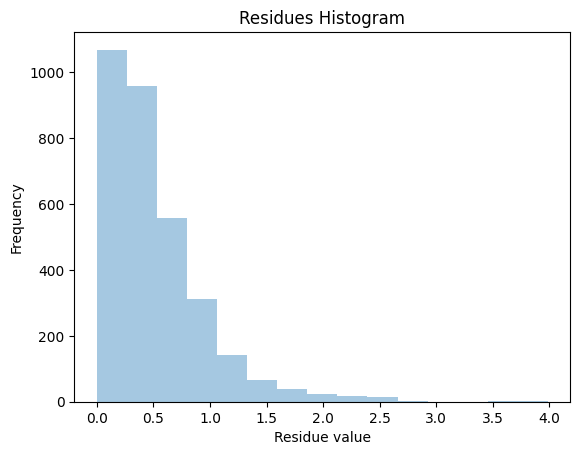

In [7]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('winequality-red.csv', delimiter=';')
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
residues, errors_original, errors_rounded = [], [], []

for i in range(1, 11):
    mlp = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', early_stopping=True, random_state=i, validation_fraction=0.2)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    residues.append(np.abs(np.array(y_pred) - np.array(y_test)))

    # for next question
    rounded_predictions = np.round(y_pred)
    rounded_predictions = np.clip(rounded_predictions, 1, 10)
    errors_original.append(mean_absolute_error(y_test, y_pred))
    errors_rounded.append(mean_absolute_error(y_test, rounded_predictions))

sns.distplot(residues, kde=False, bins=15)
plt.xlabel('Residue value')
plt.ylabel('Frequency')
plt.title('Residues Histogram')
plt.show()

2) **[1.5v] Since we are in the presence of a integer regression task, a recommended trick is to 
round and bound estimates. Assess the impact of these operations on the MAE of the MLP 
learnt in previous question.**

In [8]:
mae_original = np.mean(errors_original)
mae_rounded = np.mean(errors_rounded)

print(f"Original MAE: {round(mae_original, 5)}")
print(f"MAE after rounding and bounding: {round(mae_rounded, 5)}")

Original MAE: 0.50972
MAE after rounding and bounding: 0.43875


Podemos observar que o *MAE* após *rounding and bounding* é inferior ao original, o que nos indica que estas *predictions* estão mais próximas dos valores reais. Apesar de apresentar esta vantagem e tornar as *predictions* mais interpretáveis (por terem uma natureza mais próxima da *integer regression*), o *rounding and bounding* pode levar a uma perda significativa de precisão.

3) **[1.5v] Similarly assess the impact on RMSE from replacing early stopping by a well-defined 
number of iterations in {20,50,100,200} (where one iteration corresponds to a batch).**

In [9]:
from sklearn.metrics import mean_squared_error

for iter_num in (20, 50, 100, 200):
    errors = []
    
    for i in range(1, 11):
        mlp = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', max_iter=iter_num, random_state=i)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        errors.append(mean_squared_error(y_test, y_pred, squared=False))

    rmse = np.mean(errors)
    print(f"RMSE for MLP with max {iter_num} iterations: {round(rmse, 5)}")

RMSE for MLP with max 20 iterations: 1.40398
RMSE for MLP with max 50 iterations: 0.79961
RMSE for MLP with max 100 iterations: 0.69404
RMSE for MLP with max 200 iterations: 0.65545


4) **[1.5v] Critically comment the results obtained in previous question, hypothesizing at least 
one reason why early stopping favors and/or worsens performance.**

**R:** Se não utilizarmos *early stopping*, o fim do treino é baseado apenas nos dados de treino, o que pode levar tanto a *underfitting* (caso pare num máximo local) como a *overfitting* (caso se ajuste demasiado aos dados de treino).
O *early stopping* consiste em terminar o treino quando o *validation score* não é melhorado durante um certo número consecutivo de épocas, o que previne ambos os problemas mencionados anteriormente.

Analisando os resultados obtidos na pergunta anterior, podemos observar que com o aumento do número de iterações o erro diminui. Assim, não temos quaisquer evidências de *overfitting* (neste caso, o erro aumentaria com o número de iterações), pelo que não podemos concluir desta forma o *threshold* do *early stopping*. Posteriormente, calculámos o *RMSE* do exercício 2 (mesmo treino mas com *early stopping*), obtendo o valor 0.67065, o que nos indica que o treino original terminaria entre as 100 e as 200 iterações. O facto de o erro continuar a diminuir para um número de iterações além do *threshold* do *early stopping* ([100,200]) é algo inesperado, levando-nos a crer que os dados de validação utilizados podem não ser os mais adequados.